In [1]:
# We needed this to prevent the kernel breaks when using matplotlib and pytorch
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# import packages

import numpy as np
import math as math
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, Adam
from sklearn.preprocessing import StandardScaler

### Data Preprocessing

Shape of Original output data:  (488, 1269, 1068)


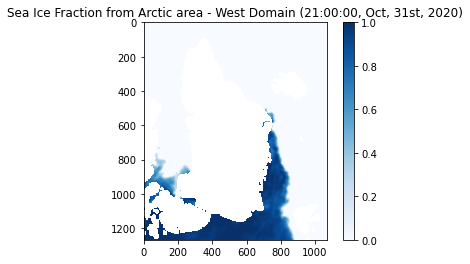

In [3]:
# load and visualize original sea ice proportion
sic_raw = np.load("sic_raw.npy")

# Original output has 1269 by 1069 grid pixels.
print("Shape of Original output data: ", sic_raw.shape)
img = plt.imshow(sic_raw[-1], cmap = 'Blues')
plt.colorbar(img)
plt.title("Sea Ice Fraction from Arctic area - West Domain (21:00:00, Oct, 31st, 2020)")
plt.show()

Shape of reduced output data:  (488, 423, 356)


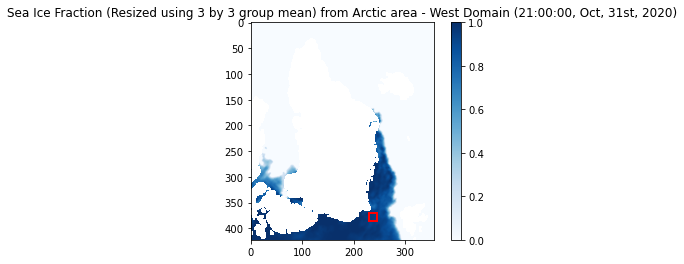

In [4]:
# reducing the size of sea ice proportion image by aggregative the 3 by 3 area average
nsmallr = sic_raw.shape[1]//3
nbigr = sic_raw.shape[1]
nsmallc = sic_raw.shape[2]//3
nbigc = sic_raw.shape[2]
sic_raw = sic_raw[:].reshape([sic_raw.shape[0], nsmallr, nbigr//nsmallr, nsmallc, nbigc//nsmallc]).mean(4).mean(2)
print("Shape of reduced output data: ", sic_raw.shape)

fig, ax = plt.subplots()
img = ax.imshow(sic_raw[-1], cmap = 'Blues')
fig.colorbar(img)

# circle the area that we are going to use for our study to predict sea ice proportion.
rect = patches.Rectangle((230,370), 15, 15, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.title("Sea Ice Fraction (Resized using 3 by 3 group mean) from Arctic area - West Domain (21:00:00, Oct, 31st, 2020)")
plt.show()

Shape of final image output data:  (488, 15, 15)


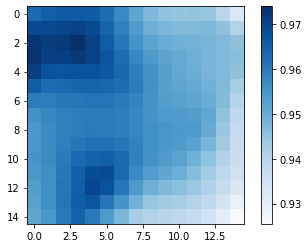

In [5]:
# We still have too many grid pixels. We only choose area with seemingly the most fluctuate in terms of sea ice proportion. 
#  The area is chosen in the red box above.
sic_raw = sic_raw[:, 370:385, 230:245]
print("Shape of final image output data: ", sic_raw.shape)

img = plt.imshow(sic_raw[-1], cmap = 'Blues')
# plt.title("Sea Ice Fraction (Resized using 3 by 3 group mean) from chosen area (21:00:00, Oct, 31st, 2020)")
plt.colorbar(img)
plt.show()

In [6]:
# The original data is more than 10gB. These data were preprocessed and saved bore this analysis.
sic = np.load("sic.npy") # sea ice proportion
si10 = np.load("si10.npy") # wind speed
msl = np.load("msl.npy") # air pressure
sst = np.load("sst.npy") # sea surface temperature
tcc = np.load("tcc.npy") # total cloud cover

In [7]:
# flattening the 2d image to 1d vector for each time step. This is needed to use sea ice proportion data in LSTM for each pixel.
sic_flat = sic.reshape((sic.shape[0], sic.shape[1]*sic.shape[2]))
si10_flat = si10.reshape((si10.shape[0], si10.shape[1]*si10.shape[2]))
msl_flat = msl.reshape((msl.shape[0], msl.shape[1]*msl.shape[2]))
sst_flat = sst.reshape((sst.shape[0], sst.shape[1]*sst.shape[2]))
tcc_flat = tcc.reshape((tcc.shape[0], tcc.shape[1]*tcc.shape[2]))

In [8]:
# We need to reshape the data so that lstm algorithm in pytorch could understand. The input feature should be 3-dimensional.
# This function will group the input and output data by the number of time sequence. In our case, we will only use sequence length of 1.

def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        # Note that we are going to concatenate the above arrays so we will have 5 input features in the end
        _x = time_series[i:i + seq_length, 0:5] # this will group the input data to the number of time sequence.
        _y = time_series[i + seq_length, [-1]] # This will also group the output sea ice proportion to the number of time sequence
                
        dataX.append(_x)
        dataY.append(_y)
        
    return np.array(dataX), np.array(dataY)

In [9]:
# check GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 
print(torch.cuda.get_device_name(0))

NVIDIA GeForce GTX 1060


### LSTM: check the performance using train and test loss

In [10]:
# Define LSTM algorithm

class LSTM1(nn.Module): 
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length): 
        super(LSTM1, self).__init__() 
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first = True) #lstm
        # batch_first is needed to define the order of output shape.
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self,x): 
        
        out, _status = self.lstm(x)
        out = self.fc(out[:,-1])

        return out

In [11]:
learning_rate = 0.05

num_epochs = 300 # This will be reduced if we find the model gets overfitted
input_size = 5 # 5 input features
hidden_size = 256
num_layers = 2 # stacked LSTM with 2 layers
seq_length = 1 # This can be modified, but we choose 1.

num_classes = 1 # Since we have output of a single variable of sea ice proportion, 1 class is reasonable.

In [12]:
n_train = 400 # Number of training set
n_test = 487-n_train # number of test set
n_pixs = sic_flat.shape[1] # total number of pixels in a time step (n-225)
n_hw = sic.shape[-1] # height and width of the image, 15 by 15

# Since we are predicting sea ice proportion of one time ahead, data from initial time step won't be used as sequence
n_seq = sic.shape[0]-1 # number of sequences. 

In [13]:
# output of predicted value will be saved.
predict_y = []
# the data need to ne scaled. We use the standard scaler in our study.
ss = StandardScaler()

# train and test loss will be saved and presented
train_loss = []
test_loss = []

for i in range(0,(sic_flat.shape[1])): # train for each pixel value
    
    # train and test loss for each pixel will be saved
    train_loss_pix = [] 
    test_loss_pix = []

    # define model (stacked LSTM)
    lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, seq_length).to(device)

    # MSE loss
    loss_function = torch.nn.MSELoss()
    # Adam optimizer
    optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

    # get data for specified pixel, i
    si10_sub = si10_flat[:,i].reshape(si10_flat.shape[0], 1)
    msl_sub = msl_flat[:,i].reshape(msl_flat.shape[0], 1)
    sst_sub = sst_flat[:,i].reshape(sst_flat.shape[0], 1)
    tcc_sub = tcc_flat[:,i].reshape(tcc_flat.shape[0], 1)
    sic_sub = sic_flat[:,i].reshape(sic_flat.shape[0], 1)

    # Scale data with standard scaling (normalize)
    si10_sub_st = ss.fit_transform(si10_sub)
    msl_sub_st = ss.fit_transform(msl_sub)
    sst_sub_st = ss.fit_transform(sst_sub)
    tcc_sub_st = ss.fit_transform(tcc_sub)
    # sic variable should be scaled last as standard scaler need to save the scaling factors of this sic.
    sic_sub_st = ss.fit_transform(sic_sub) # here the last scaling factors will be saved and be used later to denormalize an output.
    
    # data with 5 input features.
    data_all = np.array([si10_sub_st.flatten(), msl_sub_st.flatten(), sst_sub_st.flatten(), 
                         tcc_sub_st.flatten(), sic_sub_st.flatten()]).T
    
    # we will have 400 train sets and 88 test set.
    train_set = data_all[:n_train, :]
    test_set = data_all[n_train:, :]

    # Out of 400 train set, we use 399 for train input for time step 0 to 398. 
    # 399 train output for time step 1 to 399
    X_train, y_train = build_dataset(train_set, seq_length)
    
    # Out of 88 test set, we use 87 for test input for time step 400 to 486tr
    # 87 test output for time step 401 to 487
    X_test, y_test = build_dataset(test_set, seq_length)
    
    # Dataset changed to tensors.
    X_train_tensors = Variable(torch.Tensor(X_train)) 
    X_test_tensors = Variable(torch.Tensor(X_test)) 
    y_train_tensors = Variable(torch.Tensor(y_train)) 
    y_test_tensors = Variable(torch.Tensor(y_test)) 

    # Train model for the number of pixels.
    print("Pixel index is: ", i+1)
    for epoch in range(num_epochs): 
        
        outputs = lstm1.forward(X_train_tensors.to(device))
        optimizer.zero_grad() #  gradients of all optimized to zero
        
        train_loss_pix_dat = loss_function(outputs, y_train_tensors.to(device)) # MSE loss
        train_loss_pix.append(train_loss_pix_dat.item()) # loss for each epoch will be saved
        
        train_loss_pix_dat.backward() # back propagation
        optimizer.step()
        
        pred_out = lstm1.forward(X_test_tensors.to(device)) # do the same for test set
        test_loss_pix_dat = loss_function(pred_out, y_test_tensors.to(device))
        test_loss_pix.append(test_loss_pix_dat.item())
        
        if epoch % 100 == 0: 
            print("Epoch: %d, train loss: %1.5f" % (epoch, train_loss_pix_dat.item()))
            print("Epoch: %d, test loss: %1.5f" % (epoch, test_loss_pix_dat.item()))
    train_loss.append(train_loss_pix)
    test_loss.append(test_loss_pix)
    
    print("\n")

Pixel index is:  1
Epoch: 0, train loss: 1.11857
Epoch: 0, test loss: 0.37276
Epoch: 100, train loss: 0.05955
Epoch: 100, test loss: 0.05730
Epoch: 200, train loss: 0.01850
Epoch: 200, test loss: 0.13585


Pixel index is:  2
Epoch: 0, train loss: 1.09921
Epoch: 0, test loss: 0.51092
Epoch: 100, train loss: 0.05663
Epoch: 100, test loss: 0.04561
Epoch: 200, train loss: 0.02827
Epoch: 200, test loss: 0.22459


Pixel index is:  3
Epoch: 0, train loss: 1.09036
Epoch: 0, test loss: 0.34650
Epoch: 100, train loss: 0.05578
Epoch: 100, test loss: 0.01912
Epoch: 200, train loss: 0.03589
Epoch: 200, test loss: 0.07916


Pixel index is:  4
Epoch: 0, train loss: 1.09701
Epoch: 0, test loss: 0.33367
Epoch: 100, train loss: 0.05491
Epoch: 100, test loss: 0.02636
Epoch: 200, train loss: 0.02001
Epoch: 200, test loss: 0.22771


Pixel index is:  5
Epoch: 0, train loss: 1.11091
Epoch: 0, test loss: 0.37945
Epoch: 100, train loss: 0.03271
Epoch: 100, test loss: 0.02012
Epoch: 200, train loss: 0.01882
Epo

Epoch: 200, train loss: 0.01617
Epoch: 200, test loss: 0.03252


Pixel index is:  41
Epoch: 0, train loss: 1.13164
Epoch: 0, test loss: 0.41803
Epoch: 100, train loss: 0.02572
Epoch: 100, test loss: 0.01217
Epoch: 200, train loss: 0.01840
Epoch: 200, test loss: 0.01909


Pixel index is:  42
Epoch: 0, train loss: 1.13308
Epoch: 0, test loss: 0.41738
Epoch: 100, train loss: 0.01714
Epoch: 100, test loss: 0.01725
Epoch: 200, train loss: 0.01400
Epoch: 200, test loss: 0.01915


Pixel index is:  43
Epoch: 0, train loss: 1.14188
Epoch: 0, test loss: 0.48969
Epoch: 100, train loss: 0.02089
Epoch: 100, test loss: 0.01652
Epoch: 200, train loss: 0.01665
Epoch: 200, test loss: 0.03287


Pixel index is:  44
Epoch: 0, train loss: 1.14603
Epoch: 0, test loss: 0.30179
Epoch: 100, train loss: 0.01607
Epoch: 100, test loss: 0.01776
Epoch: 200, train loss: 0.01372
Epoch: 200, test loss: 0.02782


Pixel index is:  45
Epoch: 0, train loss: 1.16263
Epoch: 0, test loss: 0.49376
Epoch: 100, train loss: 0.01

Epoch: 100, train loss: 0.02878
Epoch: 100, test loss: 0.07212
Epoch: 200, train loss: 0.01877
Epoch: 200, test loss: 0.14252


Pixel index is:  81
Epoch: 0, train loss: 1.11195
Epoch: 0, test loss: 0.63144
Epoch: 100, train loss: 0.02868
Epoch: 100, test loss: 0.05796
Epoch: 200, train loss: 0.02193
Epoch: 200, test loss: 0.07896


Pixel index is:  82
Epoch: 0, train loss: 1.11141
Epoch: 0, test loss: 0.72682
Epoch: 100, train loss: 0.03148
Epoch: 100, test loss: 0.03644
Epoch: 200, train loss: 0.02450
Epoch: 200, test loss: 0.03312


Pixel index is:  83
Epoch: 0, train loss: 1.11140
Epoch: 0, test loss: 0.63343
Epoch: 100, train loss: 0.03003
Epoch: 100, test loss: 0.03217
Epoch: 200, train loss: 0.01983
Epoch: 200, test loss: 0.03729


Pixel index is:  84
Epoch: 0, train loss: 1.11926
Epoch: 0, test loss: 0.65730
Epoch: 100, train loss: 0.02142
Epoch: 100, test loss: 0.01265
Epoch: 200, train loss: 0.01560
Epoch: 200, test loss: 0.03091


Pixel index is:  85
Epoch: 0, train loss: 1.



Pixel index is:  120
Epoch: 0, train loss: 1.15142
Epoch: 0, test loss: 0.39426
Epoch: 100, train loss: 0.01837
Epoch: 100, test loss: 0.01059
Epoch: 200, train loss: 0.01570
Epoch: 200, test loss: 0.02142


Pixel index is:  121
Epoch: 0, train loss: 1.13478
Epoch: 0, test loss: 0.63997
Epoch: 100, train loss: 0.05356
Epoch: 100, test loss: 0.01542
Epoch: 200, train loss: 0.02384
Epoch: 200, test loss: 0.03119


Pixel index is:  122
Epoch: 0, train loss: 1.13272
Epoch: 0, test loss: 0.50071
Epoch: 100, train loss: 0.04731
Epoch: 100, test loss: 0.01291
Epoch: 200, train loss: 0.02684
Epoch: 200, test loss: 0.02737


Pixel index is:  123
Epoch: 0, train loss: 1.13896
Epoch: 0, test loss: 0.59904
Epoch: 100, train loss: 0.04652
Epoch: 100, test loss: 0.02245
Epoch: 200, train loss: 0.02368
Epoch: 200, test loss: 0.02133


Pixel index is:  124
Epoch: 0, train loss: 1.12660
Epoch: 0, test loss: 0.47032
Epoch: 100, train loss: 0.03412
Epoch: 100, test loss: 0.02845
Epoch: 200, train loss:

Epoch: 100, train loss: 0.02718
Epoch: 100, test loss: 0.02281
Epoch: 200, train loss: 0.02748
Epoch: 200, test loss: 0.03433


Pixel index is:  160
Epoch: 0, train loss: 1.14199
Epoch: 0, test loss: 0.66754
Epoch: 100, train loss: 0.02313
Epoch: 100, test loss: 0.04343
Epoch: 200, train loss: 0.01593
Epoch: 200, test loss: 0.12898


Pixel index is:  161
Epoch: 0, train loss: 1.13353
Epoch: 0, test loss: 0.71317
Epoch: 100, train loss: 0.02607
Epoch: 100, test loss: 0.02104
Epoch: 200, train loss: 0.01907
Epoch: 200, test loss: 0.02784


Pixel index is:  162
Epoch: 0, train loss: 1.13465
Epoch: 0, test loss: 0.79905
Epoch: 100, train loss: 0.01989
Epoch: 100, test loss: 0.03540
Epoch: 200, train loss: 0.01640
Epoch: 200, test loss: 0.04197


Pixel index is:  163
Epoch: 0, train loss: 1.13443
Epoch: 0, test loss: 0.46958
Epoch: 100, train loss: 0.01990
Epoch: 100, test loss: 0.02872
Epoch: 200, train loss: 0.03324
Epoch: 200, test loss: 0.03139


Pixel index is:  164
Epoch: 0, train los



Pixel index is:  199
Epoch: 0, train loss: 1.15852
Epoch: 0, test loss: 0.68143
Epoch: 100, train loss: 0.03402
Epoch: 100, test loss: 0.01030
Epoch: 200, train loss: 0.02179
Epoch: 200, test loss: 0.01965


Pixel index is:  200
Epoch: 0, train loss: 1.14036
Epoch: 0, test loss: 0.68638
Epoch: 100, train loss: 0.02691
Epoch: 100, test loss: 0.01570
Epoch: 200, train loss: 0.02857
Epoch: 200, test loss: 0.01522


Pixel index is:  201
Epoch: 0, train loss: 1.15263
Epoch: 0, test loss: 0.71945
Epoch: 100, train loss: 0.02695
Epoch: 100, test loss: 0.01222
Epoch: 200, train loss: 0.01925
Epoch: 200, test loss: 0.01447


Pixel index is:  202
Epoch: 0, train loss: 1.15228
Epoch: 0, test loss: 0.63186
Epoch: 100, train loss: 0.02497
Epoch: 100, test loss: 0.01560
Epoch: 200, train loss: 0.01743
Epoch: 200, test loss: 0.03094


Pixel index is:  203
Epoch: 0, train loss: 1.14548
Epoch: 0, test loss: 0.62168
Epoch: 100, train loss: 0.02800
Epoch: 100, test loss: 0.01893
Epoch: 200, train loss:

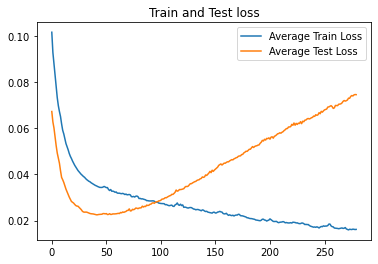

In [14]:
train_loss = np.array(train_loss)
test_loss = np.array(test_loss)

# average loss is calculated for all the pixels in each epoch
train_loss_avg = np.mean(train_loss, axis = 0)
test_loss_avg = np.mean(test_loss, axis = 0)

# plot average loss
plt.plot(train_loss_avg[20:], label='Average Train Loss') 
plt.plot(test_loss_avg[20:], label='Average Test Loss') 
plt.title('Train and Test loss')
plt.legend()
plt.show()

### LSTM: Training

In [15]:
# Based on the train and test loss plot above, the number of epochs is chosen as 40 to avoid overfitting.
num_epochs = 40 # epochs

# save training output of LSTM
all_lstm = []

ss = StandardScaler()
for i in range(0,(si10_flat.shape[1])):
    
    # This is the same for above data processing part.
    lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, seq_length).to(device)

    loss_function = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

    si10_sub = si10_flat[:,i].reshape(si10_flat.shape[0], 1)
    msl_sub = msl_flat[:,i].reshape(msl_flat.shape[0], 1)
    sst_sub = sst_flat[:,i].reshape(sst_flat.shape[0], 1)
    tcc_sub = tcc_flat[:,i].reshape(tcc_flat.shape[0], 1)
    sic_sub = sic_flat[:,i].reshape(sic_flat.shape[0], 1)

    si10_sub_st = ss.fit_transform(si10_sub)
    msl_sub_st = ss.fit_transform(msl_sub)
    sst_sub_st = ss.fit_transform(sst_sub)
    tcc_sub_st = ss.fit_transform(tcc_sub)
    sic_sub_st = ss.fit_transform(sic_sub)
    
    data_all = np.array([si10_sub_st.flatten(), msl_sub_st.flatten(), sst_sub_st.flatten(), 
                         tcc_sub_st.flatten(), sic_sub_st.flatten()]).T
    
    train_set = data_all[:n_train, :]
    test_set = data_all[n_train:, :]

    x, y = build_dataset(data_all, seq_length)

    X_train, y_train = build_dataset(train_set, seq_length)
    X_test, y_test = build_dataset(test_set, seq_length)
    
    X_train_tensors = Variable(torch.Tensor(X_train)) 
    X_test_tensors = Variable(torch.Tensor(X_test)) 
    y_train_tensors = Variable(torch.Tensor(y_train)) 
    y_test_tensors = Variable(torch.Tensor(y_test)) 

    print("Pixel index is: ", i+1)
    for epoch in range(num_epochs): 
        
        outputs = lstm1.forward(X_train_tensors.to(device))
        optimizer.zero_grad() 

        loss = loss_function(outputs, y_train_tensors.to(device)) 

        loss.backward()
        optimizer.step()

        if epoch % 10 == 0: 
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

    sub_lstm = lstm1(Variable(torch.Tensor(x)).to(device)) 
    all_lstm.append(ss.inverse_transform(sub_lstm.data.detach().cpu().numpy())) 
    # both train and test set output was denormalized and saved
    print("\n")

Pixel index is:  1
Epoch: 0, loss: 1.11223
Epoch: 10, loss: 0.25624
Epoch: 20, loss: 0.14769
Epoch: 30, loss: 0.10807


Pixel index is:  2
Epoch: 0, loss: 1.10021
Epoch: 10, loss: 0.20413
Epoch: 20, loss: 0.11158
Epoch: 30, loss: 0.08406


Pixel index is:  3
Epoch: 0, loss: 1.09350
Epoch: 10, loss: 0.35631
Epoch: 20, loss: 0.15352
Epoch: 30, loss: 0.09931


Pixel index is:  4
Epoch: 0, loss: 1.10179
Epoch: 10, loss: 0.47123
Epoch: 20, loss: 0.14676
Epoch: 30, loss: 0.08544


Pixel index is:  5
Epoch: 0, loss: 1.10882
Epoch: 10, loss: 0.28045
Epoch: 20, loss: 0.11190
Epoch: 30, loss: 0.05577


Pixel index is:  6
Epoch: 0, loss: 1.12111
Epoch: 10, loss: 0.35933
Epoch: 20, loss: 0.07716
Epoch: 30, loss: 0.04827


Pixel index is:  7
Epoch: 0, loss: 1.13405
Epoch: 10, loss: 0.37355
Epoch: 20, loss: 0.07589
Epoch: 30, loss: 0.06592


Pixel index is:  8
Epoch: 0, loss: 1.13517
Epoch: 10, loss: 0.15611
Epoch: 20, loss: 0.07618
Epoch: 30, loss: 0.04356


Pixel index is:  9
Epoch: 0, loss: 1.140

Epoch: 20, loss: 0.04968
Epoch: 30, loss: 0.04226


Pixel index is:  70
Epoch: 0, loss: 1.12840
Epoch: 10, loss: 0.27923
Epoch: 20, loss: 0.10024
Epoch: 30, loss: 0.04931


Pixel index is:  71
Epoch: 0, loss: 1.12473
Epoch: 10, loss: 0.17211
Epoch: 20, loss: 0.07119
Epoch: 30, loss: 0.04777


Pixel index is:  72
Epoch: 0, loss: 1.13523
Epoch: 10, loss: 0.23916
Epoch: 20, loss: 0.07617
Epoch: 30, loss: 0.04312


Pixel index is:  73
Epoch: 0, loss: 1.13488
Epoch: 10, loss: 0.41698
Epoch: 20, loss: 0.07827
Epoch: 30, loss: 0.04350


Pixel index is:  74
Epoch: 0, loss: 1.15097
Epoch: 10, loss: 0.13764
Epoch: 20, loss: 0.06654
Epoch: 30, loss: 0.02885


Pixel index is:  75
Epoch: 0, loss: 1.15579
Epoch: 10, loss: 0.57980
Epoch: 20, loss: 0.14627
Epoch: 30, loss: 0.07753


Pixel index is:  76
Epoch: 0, loss: 1.11375
Epoch: 10, loss: 0.34444
Epoch: 20, loss: 0.13323
Epoch: 30, loss: 0.07875


Pixel index is:  77
Epoch: 0, loss: 1.12591
Epoch: 10, loss: 0.25790
Epoch: 20, loss: 0.11093
Epoch: 

Epoch: 30, loss: 0.07905


Pixel index is:  138
Epoch: 0, loss: 1.14241
Epoch: 10, loss: 0.34950
Epoch: 20, loss: 0.14459
Epoch: 30, loss: 0.08266


Pixel index is:  139
Epoch: 0, loss: 1.13966
Epoch: 10, loss: 0.15017
Epoch: 20, loss: 0.08982
Epoch: 30, loss: 0.06230


Pixel index is:  140
Epoch: 0, loss: 1.14315
Epoch: 10, loss: 0.18587
Epoch: 20, loss: 0.10465
Epoch: 30, loss: 0.07190


Pixel index is:  141
Epoch: 0, loss: 1.13351
Epoch: 10, loss: 0.25056
Epoch: 20, loss: 0.09902
Epoch: 30, loss: 0.06882


Pixel index is:  142
Epoch: 0, loss: 1.13287
Epoch: 10, loss: 0.39144
Epoch: 20, loss: 0.09064
Epoch: 30, loss: 0.06257


Pixel index is:  143
Epoch: 0, loss: 1.13802
Epoch: 10, loss: 0.27147
Epoch: 20, loss: 0.12442
Epoch: 30, loss: 0.06759


Pixel index is:  144
Epoch: 0, loss: 1.13718
Epoch: 10, loss: 0.47858
Epoch: 20, loss: 0.09275
Epoch: 30, loss: 0.04883


Pixel index is:  145
Epoch: 0, loss: 1.13902
Epoch: 10, loss: 0.16062
Epoch: 20, loss: 0.09684
Epoch: 30, loss: 0.05088

Epoch: 30, loss: 0.04706


Pixel index is:  206
Epoch: 0, loss: 1.14440
Epoch: 10, loss: 0.13612
Epoch: 20, loss: 0.06769
Epoch: 30, loss: 0.04223


Pixel index is:  207
Epoch: 0, loss: 1.14981
Epoch: 10, loss: 0.24874
Epoch: 20, loss: 0.11437
Epoch: 30, loss: 0.05695


Pixel index is:  208
Epoch: 0, loss: 1.14578
Epoch: 10, loss: 0.24028
Epoch: 20, loss: 0.09563
Epoch: 30, loss: 0.04976


Pixel index is:  209
Epoch: 0, loss: 1.14669
Epoch: 10, loss: 0.28855
Epoch: 20, loss: 0.07222
Epoch: 30, loss: 0.03886


Pixel index is:  210
Epoch: 0, loss: 1.13929
Epoch: 10, loss: 0.18189
Epoch: 20, loss: 0.08113
Epoch: 30, loss: 0.03883


Pixel index is:  211
Epoch: 0, loss: 1.18085
Epoch: 10, loss: 0.84134
Epoch: 20, loss: 0.20672
Epoch: 30, loss: 0.13493


Pixel index is:  212
Epoch: 0, loss: 1.16330
Epoch: 10, loss: 0.31791
Epoch: 20, loss: 0.14391
Epoch: 30, loss: 0.08194


Pixel index is:  213
Epoch: 0, loss: 1.15132
Epoch: 10, loss: 0.17000
Epoch: 20, loss: 0.09422
Epoch: 30, loss: 0.05269

In [16]:
# Both predicted and estimated output was aggregated by the mean of each pixel values
all_lstm = np.array(all_lstm).reshape((n_pixs, n_seq)).T
all_lstm_mean = np.mean(all_lstm, axis = 1)

# True sea ice proportion
sic_true_mean = np.mean(sic_flat[1:,:], axis = 1)

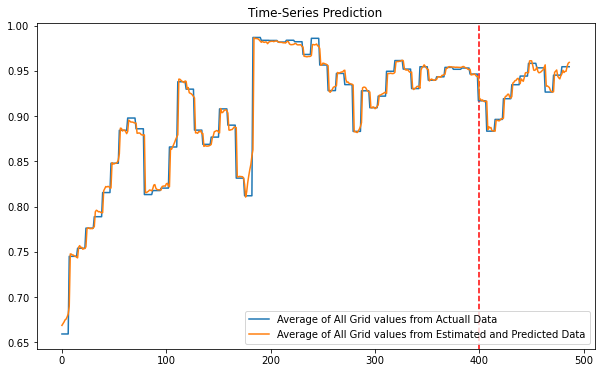

In [17]:
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=n_train, c='r', linestyle='--') #size of the training set

plt.plot(sic_true_mean, label='Average of All Grid values from Actuall Data') #actual plot
plt.plot(all_lstm_mean, label='Average of All Grid values from Estimated and Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [18]:
# reshape a vector to 2d images
all_lstm_2d = []
for i in range(n_seq):
    all_lstm_2d.append(all_lstm[i].reshape((n_hw, n_hw)))
all_lstm_2d = np.array(all_lstm_2d)

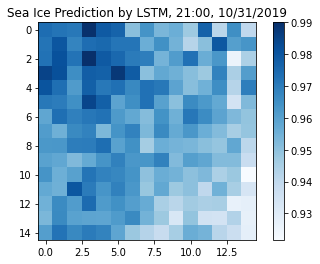

In [19]:
# Predicted sea ice proportion of 21:00:00, Oct, 31st, 2020
lstm_img_dat = all_lstm_2d[-1]
lstm_img = plt.imshow(lstm_img_dat, cmap = 'Blues')
plt.colorbar(lstm_img)
plt.title("Sea Ice Prediction by LSTM, 21:00, 10/31/2019")
plt.show()

### ConvLSTM: Define Model

In [20]:
# Original ConvLSTM cell as proposed by Shi et al.

class ConvLSTMCell(nn.Module):

    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, activation, frame_size):

        super(ConvLSTMCell, self).__init__()  

        if activation == "tanh":
            self.activation = torch.tanh 
        elif activation == "relu":
            self.activation = torch.relu
        

        self.conv = nn.Conv2d(
            in_channels = 6, # input channel for CNN should be 6 (1 for hidden state, 5 for input features (X))
            out_channels = 4*out_channels, # 4 output:input gate, output gate, forget gate and cell state
            kernel_size=kernel_size, # filter size
            padding=padding)   

#         We could use multiple layer CNN. We are only using one layer for our study.
#         input channels and output channels need to be modified accordingly.

#         self.conv1 = nn.Conv2d(
#             in_channels = 64*out_channels, 
#             out_channels = 4*out_channels, 
#             kernel_size=kernel_size, 
#             padding=padding)  
        
#         self.conv2 = nn.Conv2d(
#             in_channels = 16*out_channels, 
#             out_channels = 4*out_channels, 
#             kernel_size=kernel_size, 
#             padding=padding)  
        
        # Initialize weights for Hadamard Products
        self.W_ci = nn.Parameter(torch.rand(out_channels, *frame_size))
        self.W_co = nn.Parameter(torch.rand(out_channels, *frame_size))
        self.W_cf = nn.Parameter(torch.rand(out_channels, *frame_size))

    def forward(self, X, H_prev, C_prev):
        
        conv_output = self.conv(torch.cat([X, H_prev], dim=1))
        
#         Again, we are using just one convolutional layer.
#         conv_output1 = self.conv1(conv_output)
#         conv_output2 = self.conv2(conv_output1)
                
        i_conv, f_conv, C_conv, o_conv = torch.chunk(conv_output, chunks=4, dim=1) # defining input, output, forget gate and cell state
        
        # _conv outputs are convolution of weights and input + weights and hidden state + bias.
        input_gate = torch.sigmoid(i_conv + self.W_ci * C_prev)
        forget_gate = torch.sigmoid(f_conv + self.W_cf * C_prev)
        C = forget_gate*C_prev + input_gate * self.activation(C_conv) # Cell state
        output_gate = torch.sigmoid(o_conv + self.W_co * C)
        
        H = output_gate * self.activation(C) # hidden state

        return H, C

In [21]:
class ConvLSTM(nn.Module):

    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, activation, frame_size):

        super(ConvLSTM, self).__init__()

        self.out_channels = out_channels

        # We will unroll this over time steps
        self.convLSTMcell = ConvLSTMCell(in_channels, out_channels, 
        kernel_size, padding, activation, frame_size)

    def forward(self, X):

        batch_size, _, seq_len, height, width = X.size()

        # initial outputs and Cell and hidden states set to zero.
        # except for height and weight, all the sizes are 1 in our study.
        output = torch.zeros(batch_size, self.out_channels, seq_len, height, width, device=device) 
        
        H = torch.zeros(batch_size, self.out_channels, height, width, device=device)

        C = torch.zeros(batch_size, self.out_channels, height, width, device=device)
        
        # CNN within LSTM runs for each time steps.
        for time_step in range(seq_len):

            H, C = self.convLSTMcell(X[:,:,time_step], H, C)

            output[:,:,time_step] = H

        return output

In [22]:
# 5 input channels with 5 features,
# 1 output channel with sea ice proportion
# filter size to be 5 and padding set to 2
model = ConvLSTM(in_channels=5, out_channels=1, 
                 kernel_size=(5,5), padding=(2,2), activation="tanh", 
                 frame_size=(15, 15)).to(device)

In [23]:
# SGD optimizer is chosen,
# MSE loss
optim = Adam(model.parameters(), lr=0.01)
loss_function = torch.nn.MSELoss()

### ConvLSTM: Data preprocessing

In [24]:
# Data preprocessing for ConvLSTM
# Since we don't run the model for each pixels independently, we first process data and then run the model.

# Standardize input features.
si10_st = []
sst_st = []
msl_st = []
tcc_st = []
sic_st = []

ss = StandardScaler()
# scalers need to be saaved so that we could use this to denormalize the output data.
scalers = {}
for i in range(sic_flat.shape[0]):
    scalers[i] = StandardScaler()
    si10_sub = ss.fit_transform(si10[i,:,:])
    sst_sub = ss.fit_transform(sst[i,:,:])
    msl_sub = ss.fit_transform(msl[i,:,:])
    tcc_sub = ss.fit_transform(tcc[i,:,:])
    sic_sub = scalers[i].fit_transform(sic[i,:,:]) # save scaling factor

    si10_st.append(si10_sub)
    sst_st.append(sst_sub)
    msl_st.append(msl_sub)
    tcc_st.append(tcc_sub)
    sic_st.append(sic_sub)

si10_st = np.array(si10_st)
sst_st = np.array(sst_st)
msl_st = np.array(msl_st)
tcc_st = np.array(tcc_st)
sic_st = np.array(sic_st)

# defining train and test sets. This is the same for LSTM.
train_set_x = Variable(torch.FloatTensor([np.array([(si10_st[:n_train,:,:]), (msl_st[:n_train,:,:]), 
                                                (sst_st[:n_train,:,:]), (tcc_st[:n_train,:,:]), 
                                                (sic_st[:n_train,:,:])])]))
train_set_y = Variable(torch.FloatTensor(np.array([[(sic_st[1:(n_train+1),:,:])]])))

test_set_x = Variable(torch.FloatTensor([np.array([(si10_st[n_train:n_seq,:,:]), (msl_st[n_train:n_seq,:,:]), 
                                                (sst_st[n_train:n_seq,:,:]), (tcc_st[n_train:n_seq,:,:]), 
                                                (sic_st[n_train:n_seq,:,:])])]))
test_set_y = Variable(torch.FloatTensor(np.array([[(sic_st[(n_train+1):,:,:])]])))

# if we were to interested in predicting without sea ice proportion as input feature, then this sets need to be used for train and test sets
# train_set_x = Variable(torch.FloatTensor([np.array([(si10_st[:n_train,:,:]), (msl_st[:n_train,:,:]), 
#                                                 (sst_st[:n_train,:,:]), (tcc_st[:n_train,:,:])])]))
# test_set_x = Variable(torch.FloatTensor([np.array([(si10_st[n_train:487,:,:]), (msl_st[n_train:487,:,:]), 
#                                                 (sst_st[n_train:487,:,:]), (tcc_st[n_train:487,:,:])])]))

### ConvLSTM: check the performance using train and test loss

In [25]:
num_epochs = 500 # this is to check the performance of the model. For actual training, we will probabily reduce this.

# Save train and test loss
train_loss = []
test_loss = []

for epoch in range(num_epochs): 
    train_outputs = model.forward(train_set_x.to(device)) # both train set and test set were trained to get the loss.
    test_outputs = model.forward(test_set_x.to(device))
    optim.zero_grad() 
    
    train_loss_dat = loss_function(train_outputs, train_set_y.to(device))
    test_loss_dat = loss_function(test_outputs, test_set_y.to(device))
    
    train_loss.append(train_loss_dat.item()) # both loss are saved
    test_loss.append(test_loss_dat.item())
    train_loss_dat.backward()
    optim.step()
    if epoch % 10 == 0: 
        print("Epoch: %d, Train loss: %1.5f" % (epoch, train_loss_dat.item()))
        print("Epoch: %d, Test loss: %1.5f" % (epoch, test_loss_dat.item()))
        print("\n")

Epoch: 0, Train loss: 1.10384
Epoch: 0, Test loss: 1.01431


Epoch: 10, Train loss: 0.57046
Epoch: 10, Test loss: 0.62181


Epoch: 20, Train loss: 0.45732
Epoch: 20, Test loss: 0.50914


Epoch: 30, Train loss: 0.41187
Epoch: 30, Test loss: 0.47588


Epoch: 40, Train loss: 0.37795
Epoch: 40, Test loss: 0.44729


Epoch: 50, Train loss: 0.35853
Epoch: 50, Test loss: 0.41992


Epoch: 60, Train loss: 0.34397
Epoch: 60, Test loss: 0.40064


Epoch: 70, Train loss: 0.32997
Epoch: 70, Test loss: 0.39140


Epoch: 80, Train loss: 0.34585
Epoch: 80, Test loss: 0.42114


Epoch: 90, Train loss: 0.32004
Epoch: 90, Test loss: 0.37409


Epoch: 100, Train loss: 0.30507
Epoch: 100, Test loss: 0.34222


Epoch: 110, Train loss: 0.29330
Epoch: 110, Test loss: 0.32707


Epoch: 120, Train loss: 0.28418
Epoch: 120, Test loss: 0.31902


Epoch: 130, Train loss: 0.27350
Epoch: 130, Test loss: 0.32739


Epoch: 140, Train loss: 0.26537
Epoch: 140, Test loss: 0.31512


Epoch: 150, Train loss: 0.26074
Epoch: 150, Tes

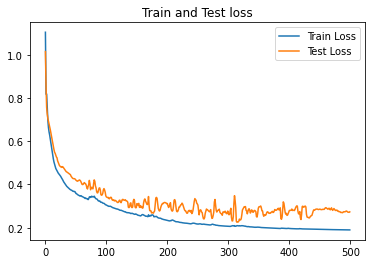

In [26]:
# train and test loss are presented
train_loss = np.array(train_loss)
test_loss = np.array(test_loss)

plt.plot(train_loss, label='Train Loss') 
plt.plot(test_loss, label='Test Loss') 
plt.title('Train and Test loss')
plt.legend()
plt.show()

### ConvLSTM: Training

In [27]:
model = ConvLSTM(in_channels=5, out_channels=1, 
                 kernel_size=(5,5), padding=(2,2), activation="tanh", 
                 frame_size=(15, 15)).to(device)

optim = SGD(model.parameters(), lr=0.1)
loss_function = torch.nn.MSELoss()

# number of epochs are reduced to 500 for efficiency.
# train ConvLSTM
num_epochs = 250
for epoch in range(num_epochs): 
    outputs = model.forward(train_set_x.to(device))
    optim.zero_grad()
    loss_convlstm = loss_function(outputs, train_set_y.to(device))
    loss_convlstm.backward() 
    optim.step() 
    if epoch % 10 == 0: 
        print("Epoch: %d, loss: %1.5f" % (epoch, loss_convlstm.item()))

Epoch: 0, loss: 0.87171
Epoch: 10, loss: 0.54078
Epoch: 20, loss: 0.49244
Epoch: 30, loss: 0.45959
Epoch: 40, loss: 0.43071
Epoch: 50, loss: 0.40626
Epoch: 60, loss: 0.38834
Epoch: 70, loss: 0.37033
Epoch: 80, loss: 0.36780
Epoch: 90, loss: 0.35039
Epoch: 100, loss: 0.34028
Epoch: 110, loss: 0.33797
Epoch: 120, loss: 0.32152
Epoch: 130, loss: 0.31062
Epoch: 140, loss: 0.30100
Epoch: 150, loss: 0.29708
Epoch: 160, loss: 0.28965
Epoch: 170, loss: 0.28547
Epoch: 180, loss: 0.28095
Epoch: 190, loss: 0.27668
Epoch: 200, loss: 0.27536
Epoch: 210, loss: 0.27588
Epoch: 220, loss: 0.26786
Epoch: 230, loss: 0.26478
Epoch: 240, loss: 0.26114


In [28]:
estimate_clstm = model(train_set_x.to(device))#forward pass
predict_clstm = model(test_set_x.to(device))#forward pass

all_clstm_2d = []
for i in range(n_train):
    all_clstm_2d.append(scalers[i+1].inverse_transform(estimate_clstm[0,0,i,:,:].data.detach().cpu().numpy()))
for i in range(n_test):
    all_clstm_2d.append(scalers[n_train+1+i].inverse_transform(predict_clstm[0,0,i,:,:].data.detach().cpu().numpy()))

all_clstm_2d = np.array(all_clstm_2d)
all_clstm = all_clstm_2d.reshape((n_seq, n_pixs))
all_clstm_mean = np.mean(all_clstm, axis = 1)

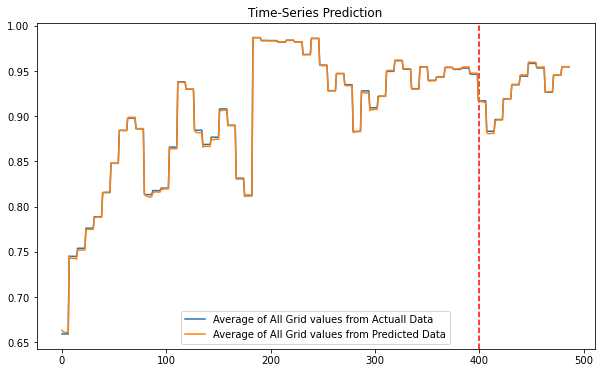

In [29]:
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=400, c='r', linestyle='--') #size of the training set

plt.plot(sic_true_mean, label='Average of All Grid values from Actuall Data') #actual plot
plt.plot(all_clstm_mean, label='Average of All Grid values from Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

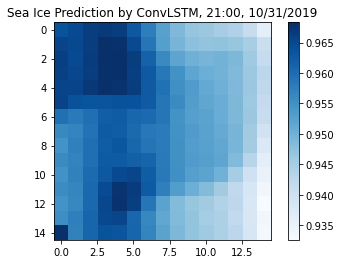

In [30]:
clstm_img_dat = plt.imshow(all_clstm_2d[-1], cmap = 'Blues')
plt.title("Sea Ice Prediction by ConvLSTM, 21:00, 10/31/2019")
plt.colorbar(clstm_img_dat)
plt.show()

### Model evlauation: Root Mean Squared Erorr, Correlation Coefficient, Mean Difference

In [31]:
# Calculate rmse for each sequence.
rmse_lstm = []
rmse_clstm = []
for i in range(n_seq):
    rmse_lstm.append(np.sqrt(np.mean((sic_flat[i+1] - all_lstm[i])**2)))
for i in range(n_seq):
    rmse_clstm.append(np.sqrt(np.mean((sic_flat[i+1] - all_clstm[i])**2)))

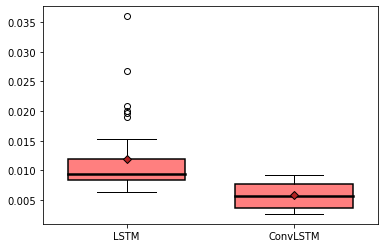

In [32]:
#  plotting rmse for prediction value from testing set
fig, ax = plt.subplots()
mprop = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick')
medprop = dict(linestyle='-', linewidth=2.5, color='black')
boxprop = dict(linestyle='-', linewidth=1.5, facecolor=(1,0,0,.5))
                
bp1 = ax.boxplot(rmse_lstm[450:], positions=[1], widths=0.7, patch_artist=True, meanprops = mprop, 
                 medianprops=medprop, boxprops=boxprop, showmeans=True)
bp2 = ax.boxplot(rmse_clstm[450:], positions=[2], widths=0.7, patch_artist=True, meanprops = mprop, 
                 medianprops=medprop, boxprops=boxprop, showmeans=True)
ax.set_xlim(0.5,2.5)
plt.xticks([1, 2], ['LSTM', 'ConvLSTM'])
plt.show()

In [33]:
# Calculate correlation coefficient for each sequence.
corr_lstm = []
for i in range(n_seq):
    corr_lstm.append(np.corrcoef(sic_flat[i+1], all_lstm[i])[0,1])
corr_clstm = []
for i in range(n_seq):
    corr_clstm.append(np.corrcoef(sic_flat[i+1], all_clstm[i])[0,1])

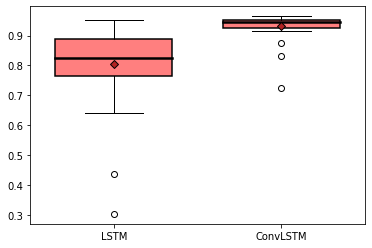

In [34]:
#  plotting correlation coefficient  for prediction value from testing set
fig, ax = plt.subplots()
bp1 = ax.boxplot(corr_lstm[450:], positions=[1], widths=0.7, patch_artist=True, meanprops = mprop, 
                 medianprops=medprop, boxprops=boxprop, showmeans=True)
bp2 = ax.boxplot(corr_clstm[450:], positions=[2], widths=0.7, patch_artist=True, meanprops = mprop, 
                 medianprops=medprop, boxprops=boxprop, showmeans=True)
ax.set_xlim(0.5,2.5)
plt.xticks([1, 2], ['LSTM', 'ConvLSTM'])
plt.show()

In [35]:
# Calculate correlation mean differnece for each sequence.
md_lstm = []
md_clstm = []
for i in range(n_seq):
    md_lstm.append(np.mean(sic_flat[i+1] - all_lstm[i]))
for i in range(n_seq):
    md_clstm.append(np.mean(sic_flat[i+1] - all_clstm[i]))

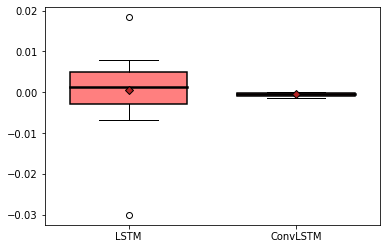

In [36]:
#  plotting mean difference  for prediction value from testing set
fig, ax = plt.subplots()
bp1 = ax.boxplot(md_lstm[450:], positions=[1], widths=0.7, patch_artist=True, meanprops = mprop, 
                 medianprops=medprop, boxprops=boxprop, showmeans=True)
bp2 = ax.boxplot(md_clstm[450:], positions=[2], widths=0.7, patch_artist=True, meanprops = mprop, 
                 medianprops=medprop, boxprops=boxprop, showmeans=True)
ax.set_xlim(0.5,2.5)
plt.xticks([1, 2], ['LSTM', 'ConvLSTM'])
plt.show()